In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from tqdm.auto import tqdm
import os
# os.chdir('src')

from build_corpus import build_corpus
from build_vocab import WordVocab
from utils import split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

import wandb
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")

#  %%
# import argparse
# parser = argparse.ArgumentParser(description='Train dpo model')
# parser.add_argument('--properties', nargs='+', required=True, 
#                     help='Properties to use (e.g., --properties affinity logps)')
# args = parser.parse_args()
# print("Properties to use: ", args.properties)
properties = ['affinity','logps']

# %%
df = pd.read_csv('../data/lck_dockstring_data1.csv')
print(df.head())

# %%
import sklearn
# minmaxscaler
from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df['qeds'] = scaler.fit_transform(df['qeds'].values.reshape(-1,1))
# df['tpsas'] = scaler.fit_transform(df['tpsas'].values.reshape(-1,1))
# df['logps'] = scaler.fit_transform(df['logps'].values.reshape(-1,1))
# df['affinity'] = scaler.fit_transform(df['affinity'].values.reshape(-1,1))

affinity_scaler = MinMaxScaler()
qed_scaler = MinMaxScaler()
logp_scaler = MinMaxScaler()
tpsas_scaler = MinMaxScaler()
sas_scaler = MinMaxScaler()

affinity_scaler.fit(df['affinity'].values.reshape(-1,1))
qed_scaler.fit(df['qed'].values.reshape(-1,1))
logp_scaler.fit(df['logp'].values.reshape(-1,1))
tpsas_scaler.fit(df['tpsa'].values.reshape(-1,1))
sas_scaler.fit(df['sas'].values.reshape(-1,1))

df['qeds'] = qed_scaler.transform(df['qed'].values.reshape(-1,1))
df['logps'] = logp_scaler.transform(df['logp'].values.reshape(-1,1))
df['tpsas'] = tpsas_scaler.transform(df['tpsa'].values.reshape(-1,1))
df['affinity'] = affinity_scaler.transform(df['affinity'].values.reshape(-1,1))
df['sas'] = sas_scaler.transform(df['sas'].values.reshape(-1,1))


# %%
# train_len = int(0.8*len(df))
# test_len = len(df) - train_len
# split_labels = np.array(['train'] * train_len + ['test'] * test_len)
# np.random.shuffle(split_labels)

# %%
# df['split'] = split_labels

# %%
SMI_MAX_SIZE= 254
# with open('../data/smiles_corpus.txt', 'w') as f:
#     train = []
#     test = []        
#     for i, row in df.iterrows():
#         if row['split'] == "test":
#             test.append(list(row.values))
#         else:
#             train.append(list(row.values))
#         f.write(split(row['smiles'] +'\n'))
        
#         if SMI_MAX_SIZE < len(row['smiles']):
#             SMI_MAX_SIZE = len(row['smiles'])
# f.close()
# print("SMI_MAX_SIZE ", SMI_MAX_SIZE, flush=True)
# train_df = pd.DataFrame(train, columns=df.columns)
# test_df = pd.DataFrame(test, columns=df.columns)
# with open('../data/train_df_with_sas.pkl', 'wb') as f:
#     pickle.dump(train_df, f)
# with open('../data/test_df_with_sas.pkl', 'wb') as f:
#     pickle.dump(test_df, f)
with open('../data/train_df_with_sas.pkl', 'rb') as f:
    train_df = pickle.load(f)
with open('../data/test_df_with_sas.pkl', 'rb') as f:
    test_df = pickle.load(f)


# %%
SMI_MAX_SIZE = 300
SMI_MIN_FREQ=1
with open("../data/smiles_corpus.txt", "r") as f:
    smiles_vocab = WordVocab(f, max_size=SMI_MAX_SIZE, min_freq=SMI_MIN_FREQ)

# %%


# class CustomTargetDataset(Dataset):
#     def __init__(self, dataframe, SmilesVocab, properties_list):
#         self.dataframe = dataframe
#         self.smiles_vocab = SmilesVocab
#         self.property_list = properties_list
#         self.build()
        
#     def build(self):
#         smiles, properties, affinities= [],[],[]
#         smiles_encoding = []
#         for i, row in self.dataframe.iterrows():
#             smi = row['smiles']
#             # newsmi = Chem.MolToSmiles(Chem.MolFromSmiles(smi))
#             newsmi = smi
#             smiles.append(newsmi)
#             smiles_encoding.append(self.smiles_vocab.to_seq(split(newsmi), seq_len=SMI_MAX_SIZE, with_eos=True, with_sos=True))
#             props = []
#             for p in self.property_list:
#                 props.append(row[p])
#             properties.append(props)

#         self.smiles_encodings = torch.tensor(smiles_encoding)
#         self.properties = torch.tensor(properties)
#         self.smiles = smiles
#         # self.affinities = torch.tensor(affinities)
#         print("dataset built")
        
#     def __len__(self):
#         return len(self.properties)
    
#     def __getitem__(self, index):
#         return {
#             "smiles_rep": self.smiles_encodings[index],
#             "properties": self.properties[index],
#             "smiles":self.smiles[index]
#         }

class CustomTargetDataset(Dataset):
    def __init__(self, df, vocab, properties_list):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.props = properties_list    

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        smi = row['smiles']
        seq = self.vocab.to_seq(split(smi), seq_len=SMI_MAX_SIZE, with_eos=True, with_sos=True)
        prop_vals = [row[p] for p in self.props]
        return {
            "smiles_rep": torch.tensor(seq, dtype=torch.long),
            "properties": torch.tensor(prop_vals, dtype=torch.float32),
            "smiles": smi
        }

# %%
class PositionalEncodings(nn.Module):
    """Attention is All You Need positional encoding layer"""

    def __init__(self, seq_len, d_model, p_dropout,n=10000):
        """Initializes the layer."""
        super(PositionalEncodings, self).__init__()
        token_positions = torch.arange(start=0, end=seq_len).view(-1, 1)
        dim_positions = torch.arange(start=0, end=d_model).view(1, -1)
        angles = token_positions / (n ** ((2 * dim_positions) / d_model))

        encodings = torch.zeros(1, seq_len, d_model)
        encodings[0, :, ::2] = torch.cos(angles[:, ::2])
        encodings[0, :, 1::2] = torch.sin(angles[:, 1::2])
        encodings.requires_grad = False
        self.register_buffer("positional_encodings", encodings)

        self.dropout = nn.Dropout(p_dropout)

    def forward(self, x):
        """Performs forward pass of the module."""
        x = x + self.positional_encodings[:,:x.shape[1],:]
        x = self.dropout(x)
        return x

# %%
class PropertyEncoder(nn.Module):
    def __init__(self, d_model, n_properties):
        super(PropertyEncoder, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(1, d_model) for _ in range(n_properties)])
        self.layer_final = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(n_properties)])
    def forward(self, x):
        outs = [self.layer_final[i](F.relu(self.layers[i](x[:,i].unsqueeze(1)))) for i, layer in enumerate(self.layers)]
        # for i, layer in enumerate(self.layers):
        #     out = self.layers[i](x[:,i])
        #     out = F.relu(out)
        #     x = self.layer_final[i](out)        
        return torch.stack(outs, dim=1)

# %%
def set_up_causal_mask(seq_len):
    mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    mask.requires_grad = False
    return mask

# %%
class SmileDecoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, vocab, n_properties, hidden_units=1024, dropout=0.1):
        super(SmileDecoder, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.vocab = vocab
        self.dropout = dropout
        
        self.embed = nn.Embedding(len(vocab), d_model)
        self.smile_pe = PositionalEncodings(SMI_MAX_SIZE, d_model, dropout)
        
        self.trfmLayer = nn.TransformerDecoderLayer(d_model=d_model,
                                                    nhead=n_heads,
                                                    dim_feedforward=hidden_units,
                                                    dropout=dropout,
                                                    batch_first=True,
                                                    norm_first=True,
                                                    activation="gelu")
        self.trfm = nn.TransformerDecoder(decoder_layer=self.trfmLayer,
                                          num_layers=n_layers,
                                          norm=nn.LayerNorm(d_model))
        self.ln_f = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, len(vocab))

        # Property side: per-property projection + encoder
        self.property_encoder = PropertyEncoder(d_model, n_properties=n_properties)
        self.prop_pe = PositionalEncodings(n_properties, d_model, dropout)
        self.prop_enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=hidden_units,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
            activation="gelu"
        )
        self.prop_encoder = nn.TransformerEncoder(
            encoder_layer=self.prop_enc_layer,
            num_layers=n_layers,
            norm=nn.LayerNorm(d_model)
        )
        
        
    def forward(self, x, property):
        # Encode properties -> contextual memory
        prop_feats = self.property_encoder(property)          # (B, P, D)
        prop_feats = self.prop_pe(prop_feats)                 # (B, P, D)
        memory = self.prop_encoder(prop_feats)                # (B, P, D)
        
        x = self.embed(x)
        x = self.smile_pe(x)
    
        mask = set_up_causal_mask(x.shape[1]).to(x.device)
        x = self.trfm(tgt=x,
                      memory=memory,
                      tgt_mask=mask,
                      )
        x = self.ln_f(x)
        x = self.classifier(x)
        return x

# %%
# import nn.utils.clip_grad_value_
# import nn.utils.clip_grad_value_
def train_step(model, data_loader, optimizer,epoch):
    running_loss = []
    model.to(device)
    model.train()
    for i, data in enumerate((data_loader)):
        # data = {k: v.to(device) for k, v in data.items()}
        data['smiles_rep'] = data['smiles_rep'].to(device)
        data['properties'] = data['properties'].to(device)
        
        optimizer.zero_grad()
        out = model(data['smiles_rep'], data['properties'])
        out = out[:,:-1,:]
        y = data['smiles_rep'][:,1:]
        loss = F.cross_entropy(out.contiguous().view(-1, len(smiles_vocab)),y.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        running_loss.append(loss.item())
        print( 'Training Epoch: {} | iteration: {}/{} | Loss: {}'.format(epoch, i, len(data_loader), loss.item() ), end='\r',flush=True)
        
    return np.mean(running_loss)
        
def val_step(model, data_loader, epoch):
    running_loss = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate((data_loader)):
            # data = {k: v.to(device) for k, v in data.items()}
            data['smiles_rep'] = data['smiles_rep'].to(device)
            data['properties'] = data['properties'].to(device)
            
            out = model(data['smiles_rep'], data['properties'])
            out = out[:,:-1,:]
            y = data['smiles_rep'][:,1:]
            loss = F.cross_entropy(out.contiguous().view(-1, len(smiles_vocab)),y.contiguous().view(-1))
            running_loss.append(loss.item())
            print( 'Validating Epoch: {} | iteration: {}/{} | Loss: {}'.format(epoch, i, len(data_loader), loss.item() ), end='\r',flush=True)
        
    return np.mean(running_loss)

# %%
import os
import yaml

def save_model(model, config):
    path_dir = '../checkpoints/'+ config['run_name']
    if not os.path.exists(path_dir):
        os.mkdir(path_dir)
    model_path = path_dir + '/' + 'model' + '.pt'
    config_path = path_dir + '/config.yaml'
    torch.save(model.state_dict(), model_path)
    with open(config_path,'w') as yaml_file:
        yaml.dump(dict(config), yaml_file)
        

# %%
class Sampler:
    def __init__(self, model, vocab):
        self.model = model
        self.vocab = vocab
    
    def sample(self, properties, greedy=False):
        samples = []
        with torch.no_grad():
            property = properties.to(device)
            smiles_seq = torch.full((property.shape[0], 1), self.vocab.stoi["<sos>"]).long().to(device)
            # print(smiles_seq)
            # return
            
            for i in range(SMI_MAX_SIZE):
                logits = self.model.forward(smiles_seq, property)
                # print(logits.shape)
                probs = F.softmax(logits[:,-1], dim= -1)
                # print(probs.shape)
                # break
                if greedy:
                    pred_id = torch.argmax(probs, dim= -1)
                    pred_id = pred_id.unsqueeze(1)
                else:
                    pred_id = torch.multinomial(probs, num_samples=1)
                # print(pred_id.shape)
                # break
                smiles_seq = torch.cat([smiles_seq, pred_id], dim=1)
                
            for i in range(len(smiles_seq)):
                smile = self.vocab.from_seq(smiles_seq[i].cpu().numpy())
                final_smile = ""
                for char in smile[1:]: # first is start token
                    if char == "<eos>" :
                        break
                    final_smile += char
                samples.append(final_smile)
        return samples
            

# %%
def sample_a_bunch(model, dataloader, greedy=False):
    sampler = Sampler(model, smiles_vocab)
    model.eval()
    samples = []
    properties = []
    og_smiles = []
    with torch.no_grad():
        for i, data in enumerate((dataloader)):
            # data = {k: v.to(device) for k, v in data.items()}
            smiles = sampler.sample(data['properties'].to(device), greedy=greedy)
            properties += data['properties'].cpu().numpy().tolist()
            ogs = data['smiles']
            samples += smiles
            og_smiles += ogs
            print( 'Sampling: iteration: {}/{}'.format(i, len(dataloader)), end='\r',flush=True)
            if len(samples) >= 1000:
                break
    return np.array(properties), samples, og_smiles
# %%

from rdkit import Chem

def is_valid_smiles(smiles):
    """Check if a SMILES string is valid."""
    return Chem.MolFromSmiles(smiles) is not None

def compute_metrics(train_SMILES, test_SMILES, predicted_SMILES):
    # Compute validity
    valid_predicted = [smiles for smiles in predicted_SMILES if is_valid_smiles(smiles)]
    validity = len(valid_predicted) / len(predicted_SMILES) if predicted_SMILES else 0

    # Compute novelty
    novel_predicted = [smiles for smiles in valid_predicted if smiles not in train_SMILES]
    novelty = len(novel_predicted) / len(valid_predicted) if valid_predicted else 0

    # Compute uniqueness
    unique_predicted = set(valid_predicted)
    uniqueness = len(unique_predicted) / len(valid_predicted) if valid_predicted else 0

    return {
        'Validity': validity,
        'Novelty': novelty,
        'Uniqueness': uniqueness
    }


def run(config):
    PROPERTIES = config['properties']
    train_dataset = CustomTargetDataset(train_df, smiles_vocab, properties_list=PROPERTIES)
    test_dataset = CustomTargetDataset(test_df, smiles_vocab, properties_list=PROPERTIES)
    train_SMILES = train_df['smiles'].tolist()

    batch_size = config['batch_size'] # Define your batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    data = next(iter(train_loader))
 
    model = SmileDecoder(d_model=config['d_model'], 
                   n_heads=config['n_heads'], 
                   n_layers=config['n_layers'], 
                   vocab=smiles_vocab, 
                   n_properties=len(PROPERTIES), 
                   hidden_units=config['hidden_units'],
                   dropout=0.1)
    model = torch.nn.parallel.DataParallel(model)
    path_dir = '../checkpoints/'+ config['run_name'] + '/model.pt'
    model.load_state_dict(torch.load(path_dir,weights_only=True,map_location=device))
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    model.to(device)
    num_gpus = torch.cuda.device_count()
    print("No of GPUs available", num_gpus)

    
    
    tl = []
    vl = []
    

    wandb.init(project="molgpt2.0 FINAL", config=config, name=config['run_name'])
    wandb.watch(models=model, log_freq=100)
    print(config)

    sampler = Sampler(model, smiles_vocab)
    All_samples = []
    for i in (range(config['epochs'])):
        time_start = time.time()
        train_loss = train_step(model, train_loader, optimizer,i)
        val_loss = val_step(model, test_loader, i)
        tl.append(train_loss)
        vl.append(val_loss)
        wandb.log({"train_loss": train_loss, "val_loss": val_loss}, step=i)
        save_model(model, config)
        
        if i % 10 == 0 and i!=0:
            properties, pred_SMILES, test_SMILES  = sample_a_bunch(model, test_loader, greedy=False)
            results = compute_metrics(train_SMILES, test_SMILES, pred_SMILES)
            for key in results:
                print(f"{key}: {results[key]}")
            df = pd.DataFrame({"SMILES":pred_SMILES})
            df.to_csv('../checkpoints/'+config['run_name']+'/sampled_mols.txt')
        time_end = time.time()
        print(f"Time Taken for Epoch {i} : {time_end - time_start} seconds",flush=True)
            
                
                
            
        
        

# %%
# columns = ['smiles', 'affinity', 'logps', 'qeds', 'tpsas', 'split']
config = {
    'batch_size' : 128,
    'd_model': 512,
    'n_heads': 8,
    'n_layers':6,
    'hidden_units': 512,
    'lr': 1e-5,
    'epochs': 200,
    'properties': sorted(properties) # change here for different properties,
}
config['run_name'] = "LCK_DOCKSTRING_FAST_ACTUAL_"+ "_".join(prop for prop in config['properties'])
print(config)

# %%
# import time
# start_time = time.time()
# run(config)
# end_time = time.time()
# print(f"Total training time: {end_time - start_time} seconds")

/home2/bhuvan.kapur/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.5.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home2/bhuvan.kapur/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


device : cpu
   Unnamed: 0                                             smiles       qed  \
0           0         O=C1C(=O)C(c2ccc(O)c(O)c2)Oc2cc(O)cc(O)c21  0.463229   
1           1                   O=S(=O)(c1cccc2cnccc12)N1CCCNCC1  0.903457   
2           2                    CCN1/C(=C/C(C)=O)Sc2ccc(OC)cc21  0.770003   
3           3  Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...  0.389416   
4           4                        c1ccc2c(-c3ccncc3)c[nH]c2c1  0.632617   

     tpsa     logp       sas    molwt  affinity  
0  124.29  1.39450  3.160078  302.238      -8.1  
1   62.30  1.21880  2.211947  291.376      -7.8  
2   29.54  3.05760  2.464484  249.335      -6.1  
3   86.28  4.59032  2.331660  493.615      -9.3  
4   28.68  3.22990  1.819967  194.237      -6.8  
Building Vocab
{'batch_size': 128, 'd_model': 512, 'n_heads': 8, 'n_layers': 6, 'hidden_units': 512, 'lr': 1e-05, 'epochs': 200, 'properties': ['affinity', 'logps'], 'run_name': 'LCK_DOCKSTRING_FAST_ACTUAL_affinity_log

In [ ]:
def load_model(config):
    path_dir = '../checkpoints/'+ config['run_name']
    model_path = path_dir + '/' + 'model' + '.pt'
    model = SmileDecoder(d_model=config['d_model'], 
                   n_heads=config['n_heads'], 
                   n_layers=config['n_layers'], 
                   vocab=smiles_vocab, 
                   n_properties=len(config['properties']), 
                   hidden_units=config['hidden_units'],
                   dropout=0.1)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    model.to(device)
    num_gpus = torch.cuda.device_count()
    print("No of GPUs available", num_gpus)
    try:
        model = torch.nn.parallel.DataParallel(model)
        model.load_state_dict(torch.load(model_path))
    except RuntimeError:
        model = SmileDecoder(d_model=config['d_model'], 
                   n_heads=config['n_heads'], 
                   n_layers=config['n_layers'], 
                   vocab=smiles_vocab, 
                   n_properties=len(config['properties']), 
                   hidden_units=config['hidden_units'],
                   dropout=0.1)
        model.to(device)
        model.load_state_dict(torch.load(model_path))
        model = torch.nn.parallel.DataParallel(model)
    model.eval()
    return model

In [4]:
model = load_model(config)

/home2/bhuvan.kapur/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


No of GPUs available 0


/home2/bhuvan.kapur/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [11]:
import pickle
generated_molecules = pickle.load(open('../checkpoints/LCK_DOCKSTRING_FAST_ACTUAL_affinity/generated_molecules.pkl', 'rb'))
print(f"Loaded {len(generated_molecules)} generated molecules.")
print(generated_molecules['-9']) 

Loaded 5 generated molecules.
['N1(C([C@@H](NC(CN2C([C@@H](NS(=O)(=O)CCC3=CC=CC=C3)CCCC2)=O)=O)CCC1)O)C(=N)N', 'FC=1C(C(NC(=O)CCC=2C3=C(OC2C)C=C(OC)C=C3)C4=CC=CN=C4)=CC=CC1', 'BrC=1C=C(COC=2C=3C(N=C(O)C2)=C(NCC4=CC=CC=C4)C=CC3)C=CC1', 'S(=O)(=O)(N(CC)CC)C=1C=C(C(=O)NC2C3CC4(O)CC2CC(C3)C4)C(OC)=CC1', 'ClC1=C(CCOC2=CC=3OC(=O)C=C(C3C=C2)C)C=CC4=C1OC(=O)C=C4', 'FC(F)OC1=C(OC)C=C(NC(=O)C=2C3=C(N=C(C2)C4=CC=CC=C4)C=CC=C3)C=C1', 'S(N[C@@H](C(N[C@H](C(N[C@H](C(C1=NC=CS1)=O)CCCN=C(N)N)=O)CC2=CC(=CC=C2)OC)=O)CC=3C=CC(=CC3)OC)(=O)(=O)CC4=CC=CC=C4', 'ClC=1C(C(=O)NC2=CC=C(S(=O)(=O)NC3=NOC(=C3)C)C=C2)=CC=C(F)C1', 'S(NC(C(N1CCC(CC1)C)=O)CC=2SC3=CC=NC(=C3C2)N)(C=4C5=C(C=CC4)C=CC=C5)(=O)=O', 'S1(=O)C2=C(N(CC3=CC=CC=C3)C(=O)C4=C1C=CC=C4)C=C(C(=O)NCCN(CC)CC)C=C2', 'O=C1N2/C(/[C@]3(N[C@@H](C2)CCC4=CC=CC=C4)C5=C(NC3=O)C=CC=C5)=CC(=C1CN6CCCC6)C#N', 'C1=2C(C=3C=4C(=CC=CC4)C(=CC3NC1=CC(=C(C2)OC)OC)OC)=O', 'S1(=O)(=O)N([C@H]([C@]2(F)C1)CCNC2=O)CC3=CC(F)=CC(F)=C3', 'C=1(N=CC=C(N1)C=2C(=NOC2C)C)NC=3C=CC(=C(C3)Cl

In [12]:
import pickle
generated_molecules = pickle.load(open('../checkpoints/DPO_Finetuning_BETA_0.11_epochs_10_LCK_DOCKSTRING_FAST_ACTUAL_affinity/generated_molecules.pkl', 'rb'))
print(f"Loaded {len(generated_molecules)} generated molecules.")
print((generated_molecules['-10']) )

Loaded 5 generated molecules.
['S(=O)(=O)(N1C[C@@H]2[C@@H]([C@H]3C[C@H]2CC3)[C@@H]([C@@H]1C=4C=C5N(N=CC(=N5)CCC6=CC=CC=C6)C4)C)C7=CC=C(C=C7)C', 'C(=O)(C1=CC(=C(CC=2C=C(OC2C1)C3=CC=NC=C3)O[C@@H](C4=CC=CC=C4)C)O)N5C=NC=C5', 'N=1C=C(C(C2=CNC(=C2)C(O)=O)=NC1NC=3C=CC(=CC3F)F)C4=COC5=C4C=CC=C5', 'N(NC(=N)C)C(=O)NC(C(=O)NC1=CC2=C(C=CN=C2C=C1O)C=3C=CC(=C(C3)Cl)OC)=O', 'C=1(CN2C(CC(N[C@H](C(N[C@H]3C4CC5=C([C@H]3CCCC5)C=CC(=C4)N)=O)CC6CCCC6)=C(N)C=N2)=CC=C(C1)C(=O)N', 'C=12C(=NN=C(C1)C3=C(F)C=CC=C3)C4=CC=CC=C4C2=O', 'C=1C=2N(N=C(C1)OC=3C=C4C(=CC3)N=C(N4)C5=CC=CO5)C=6N=C(N=CC6N2)NC', 'C12([C@]3(C(=CC4=C(C3)C=NN4C=5C=CC(=CC5)F)CCC1)C)O[C@H](C)[C@H](O2)C', 'C1(=CC(=C2C(=C1)N=NC(=N2)NC=3C=CC(=CC3)OCCN4CCN(CC4)C)C)C5=C(C=CC=C5C)C', 'C1(C(N(C)C(N)=O)=O)=CC=C(C2=CC3=C(/C=C/C4=CC(C(=O)NC)=CC=C4)NC5=C3C=CC(=C5)Br)NC(=C2)CC1', 'C=12C(=NC=3C(C1O)=CC=CC3)C(C4=CC=5OCOC5C=C4)N(C2)C(C=6OC(C7=CSC=C7)=CC6)=O', 'C1[C@]2(CC3CC1CC(C2)[C@@H]3NC(=O)C(N4CCN(C5CCC(C5)N6C7=C(N=C6O)C=CC=C7)CC4)(C)C)O', 'C=1(N(N=C(C1)C)C=

In [1]:
import torch
num_gpus = torch.cuda.device_count()
print("No of GPUs available", num_gpus)

No of GPUs available 4


In [2]:
import pandas as pd
import rdkit
import rdkit.Chem as Chem
import tqdm
import pickle
import random
from rdkit.Chem import Draw

In [3]:
with open("valid_smiles_encoder.pkl","rb") as f:
    valid_smiles = pickle.load(f)
print(valid_smiles)


['S1C(=NC(CNC2=CC=CC=C2)=C1)NCCC3=CC(OCC)=C(OC)C(OCC)=C3', 'N1=C2C(=C(C=C1N)N)C(=C(C=N2)C3=C(C=C(C=C3)N)F)C(F)(F)F', 'N1=C(N=C2N(C=3C=CC=CC3)C=NC2=C1N)N4C=C(C=C4)F', 'N1(C(=O)C2=C(NC(=C2C1=O)C=3C=CC(=CC3)OC)O)CC(C(NC4CCCCCC4)=O)CC(=O)O', 'O=C(NCC(=O)NC=1C(=CC=CC1)C)C=2C=C(NC(=O)C=3C=CC=CC3)C=CC2', 'OC=1C=C(N2CCCC2)C=3C(C=4C(C3C1)=CC=CC4)=NC(NC=5C=CC(=CC5)C(N)=O)=O', 'S(CNC(O)=NC(=O)C=1C(C(=CC=CC1)C)=C)C=2SC=CC2', 'S1C2=C(CCN(C2)C(=NC(OCC)=O)CC(=O)C=3C=CC(=CC3)C)C=C1C(F)(F)F', 'BrC=1SC(NC(=O)CN2C=3C(OC=4C(F)=CC=CC4)=CC=CC3N=C2N5CCCC5)=CC1', 'O=C1N(CC(C)(C)C)C(=O)COC1CCOC=2C=C(CC(=O)N3C(CCC(C)C)C(OC)=NC3=O)C=CC2', 'O=C1N(C=2C(C1C(=O)N3CCC(CC3)C(=O)NCCC(C)C)=CC=CC2)CCCCCC', 'ClC1=C(OCC(=O)NC2CC(N3N=C(C=C3C)C(C)C)CC2)C=CC=C1', 'O(C=1C=CC(C(=O)O)=CC1)CC(=O)C=2C=CC=CC2', 'O1C(CNC=2N(N=NN2)C=3C(C=C(C3)C)(C)C)=CC=C1C', 'O1[C@H](C2CC[C@@H]1NCCCCO)CC=C2', 'S1C(CNC(=O)CCC(=O)N2C(CCCC2)C(=O)O)=CC=3C1=CC=CC3', 'ClC1=CC=C(/C=C\\2/SC(=S)N2)C=C1', 'C1(=NC(C=C1CC)=O)NC=2C(O)=C(C=CC2C)OC', 'ClC1=C(N=C(O

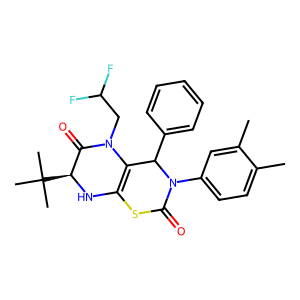

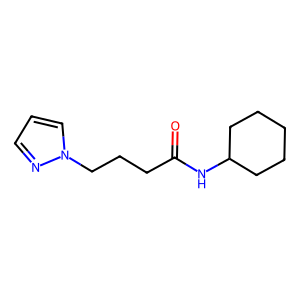

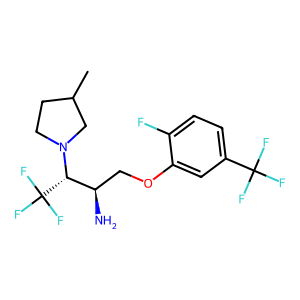

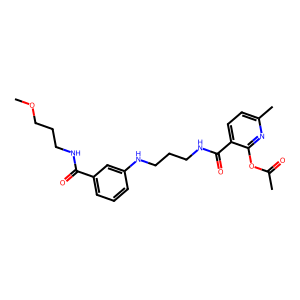

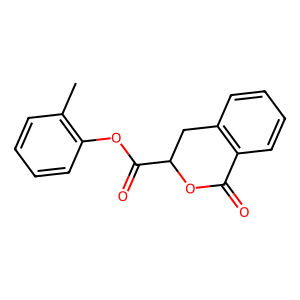

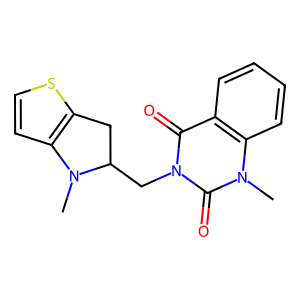

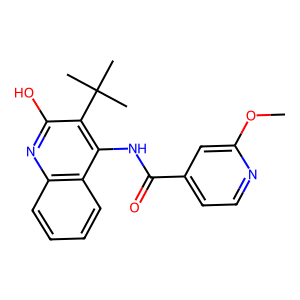

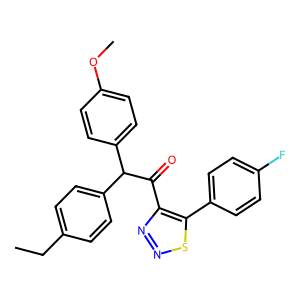

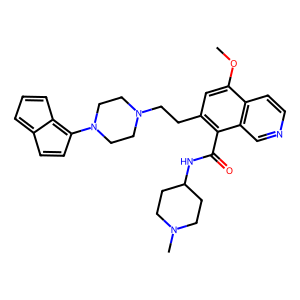

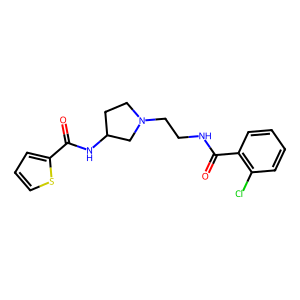

In [4]:
indices = []
import random
for i in range(10):
    indices.append(random.randint(0,len(valid_smiles)))
for idx in indices:
    mol = Chem.MolFromSmiles(valid_smiles[idx])
    img = Draw.MolToImage(mol, size=(300, 300))
    display(img)


In [5]:
import dockstring
from dockstring import load_target
target = load_target('LCK')
score, _ =  target.dock(valid_smiles[random.randint(0,len(valid_smiles))], num_cpus=2)

FileNotFoundError: [Errno 2] No such file or directory: 'obabel'